In [2]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Import NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import libraries for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set plot style
sns.set(style="whitegrid")

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Yousef
[nltk_data]     Moustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yousef
[nltk_data]     Moustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Load the training and testing datasets

train_df = pd.read_csv("twitter_training.csv", header=None)
test_df = pd.read_csv("twitter_test.csv", header=None)

# Display the first 5 rows of the training data
print("Training Data Head:")
display(train_df.head())

# Display the first 5 rows of the testing data
print("\nTesting Data Head:")
display(test_df.head())

Training Data Head:


,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...



Testing Data Head:


,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [18]:
# --- Initial Data Inspection ---

# Check for missing values in the training data
print("Missing values in training data:")
print(train_df.isnull().sum())

# Drop rows with missing text content (text is in column 3)
train_df.dropna(subset=[3], inplace=True)
test_df.dropna(subset=[3], inplace=True)

# --- Handling Duplicates ---

# Check the number of duplicate rows based on the text column (column 3)
print(f"\nNumber of duplicate tweets in training data (by text): {train_df.duplicated(subset=[3]).sum()}")

# Remove duplicate tweets to prevent data leakage
train_df.drop_duplicates(subset=[3], keep='first', inplace=True)
print(f"Shape of training data after dropping duplicates: {train_df.shape}")

# --- Handling Meaningless Short Tweets ---

# Calculate the word count for each tweet (based on text column 3)
train_df['word_count'] = train_df[3].astype(str).apply(lambda x: len(x.split()))

# Remove tweets with less than 3 words
initial_rows = train_df.shape[0]
train_df = train_df[train_df['word_count'] >= 3].copy()
removed = initial_rows - train_df.shape[0]
print(f"\nRemoved {removed} tweets with less than 3 words.")
print(f"Final shape of cleaned training data: {train_df.shape}")

# Optionally drop the helper column
train_df.drop(columns=['word_count'], inplace=True)

Missing values in training data:
0    0
1    0
2    0
3    0
dtype: int64

Number of duplicate tweets in training data (by text): 0
Shape of training data after dropping duplicates: (67326, 4)

Removed 0 tweets with less than 3 words.
Final shape of cleaned training data: (67326, 5)


In [23]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# import pandas as pd # (Assuming pandas is already imported)

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Cleans text data:
    - Handles NaN/non-string values
    - Lowercase
    - Remove URLs, mentions, hashtags, punctuation, numbers
    - Tokenize, remove stop words, and lemmatize
    """
    
    # 0. Handle NaN or non-string values
    if not isinstance(text, str):
        return "" 
    
    # 1. Lowercase
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Remove mentions and hashtags sign
    text = re.sub(r'\@\w+|\#','', text)
    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 5. Remove numbers
    text = re.sub(r'\d+', '', text)
    # 6. Tokenization
    tokens = text.split()
    # 7. Remove stop words and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return " ".join(cleaned_tokens)

# -----------------------------------------------------------------
# Determine the correct text column dynamically to avoid KeyError
# -----------------------------------------------------------------
# Default expected name (keeps backward compatibility)
TEXT_COLUMN_NAME = 'text_column'

# If the named column isn't present, try known index 3 (your dataset uses column 3 for text)
if TEXT_COLUMN_NAME not in train_df.columns:
    if 3 in train_df.columns:
        TEXT_COLUMN_NAME = 3
        print("INFO: 'text_column' not found. Using column 3 as text column.")
    else:
        # Fallback: choose the object-typed column with the largest average string length
        obj_cols = [c for c in train_df.columns if train_df[c].dtype == object]
        if obj_cols:
            col_lengths = train_df[obj_cols].astype(str).applymap(len).mean()
            TEXT_COLUMN_NAME = col_lengths.idxmax()
            print(f"INFO: 'text_column' not found. Detected '{TEXT_COLUMN_NAME}' as the text column based on average length.")
        else:
            raise KeyError("No suitable text column found in train_df. Please set TEXT_COLUMN_NAME manually to the correct column name or index.")

# Apply the cleaning function to the specific text column
print(f"Cleaning training data using column: {TEXT_COLUMN_NAME!r} ...")
train_df[TEXT_COLUMN_NAME] = train_df[TEXT_COLUMN_NAME].apply(clean_text)

print(f"Cleaning testing data using column: {TEXT_COLUMN_NAME!r} ...")
# If the test dataframe has a different column structure, try to map accordingly:
if TEXT_COLUMN_NAME in test_df.columns:
    test_df[TEXT_COLUMN_NAME] = test_df[TEXT_COLUMN_NAME].apply(clean_text)
else:
    # try to use column 3 in test_df as a likely fallback
    if 3 in test_df.columns:
        test_df[3] = test_df[3].apply(clean_text)
        print("INFO: Applied cleaning to test_df column 3 as fallback.")
    else:
        # attempt to detect similarly for test_df
        obj_cols_test = [c for c in test_df.columns if test_df[c].dtype == object]
        if obj_cols_test:
            col_lengths_test = test_df[obj_cols_test].astype(str).applymap(len).mean()
            chosen = col_lengths_test.idxmax()
            test_df[chosen] = test_df[chosen].apply(clean_text)
            print(f"INFO: Applied cleaning to detected test_df column '{chosen}'.")
        else:
            raise KeyError("No suitable text column found in test_df. Please set TEXT_COLUMN_NAME manually for test_df.")

# Display a sample of cleaned text
print("\nSample of cleaned text (first 5 rows):")
display(train_df.head())

INFO: 'text_column' not found. Using column 3 as text column.
Cleaning training data using column: 3 ...
Cleaning testing data using column: 3 ...

Sample of cleaned text (first 5 rows):


,0,1,2,3
0,2401,Borderlands,Positive,im getting borderland murder
1,2401,Borderlands,Positive,coming border kill
2,2401,Borderlands,Positive,im getting borderland kill
3,2401,Borderlands,Positive,im coming borderland murder
4,2401,Borderlands,Positive,im getting borderland murder


In [25]:
# Define features (X) and target (y)
# Use the detected text column for X and the label column (column 2) for y
X = train_df[TEXT_COLUMN_NAME].astype(str)
y = train_df[2].astype(str)

# --- Bag-of-Words (BoW) Vectorization ---
bow_vectorizer = CountVectorizer(max_features=5000) # Limit to the top 5000 words
X_bow = bow_vectorizer.fit_transform(X)

# --- TF-IDF Vectorization ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit to the top 5000 words
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"Shape of BoW matrix: {X_bow.shape}")
print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")

Shape of BoW matrix: (67326, 5000)
Shape of TF-IDF matrix: (67326, 5000)


--- Training Logistic Regression with BoW ---

Classification Report for Logistic Regression with BoW:
              precision    recall  f1-score   support

  Irrelevant       0.69      0.60      0.64      2375
    Negative       0.74      0.78      0.76      4105
     Neutral       0.71      0.65      0.68      3330
    Positive       0.70      0.76      0.73      3656

    accuracy                           0.71     13466
   macro avg       0.71      0.70      0.70     13466
weighted avg       0.71      0.71      0.71     13466



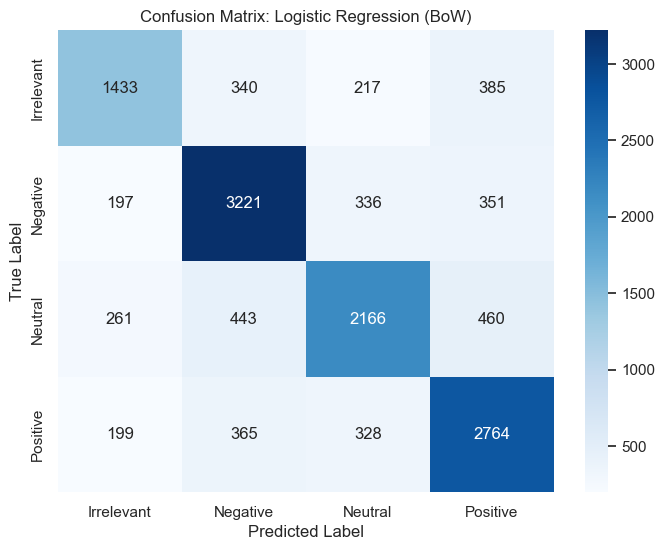

--- Training Naive Bayes with BoW ---

Classification Report for Naive Bayes with BoW:
              precision    recall  f1-score   support

  Irrelevant       0.61      0.52      0.56      2375
    Negative       0.67      0.74      0.70      4105
     Neutral       0.65      0.53      0.58      3330
    Positive       0.63      0.72      0.67      3656

    accuracy                           0.65     13466
   macro avg       0.64      0.63      0.63     13466
weighted avg       0.64      0.65      0.64     13466



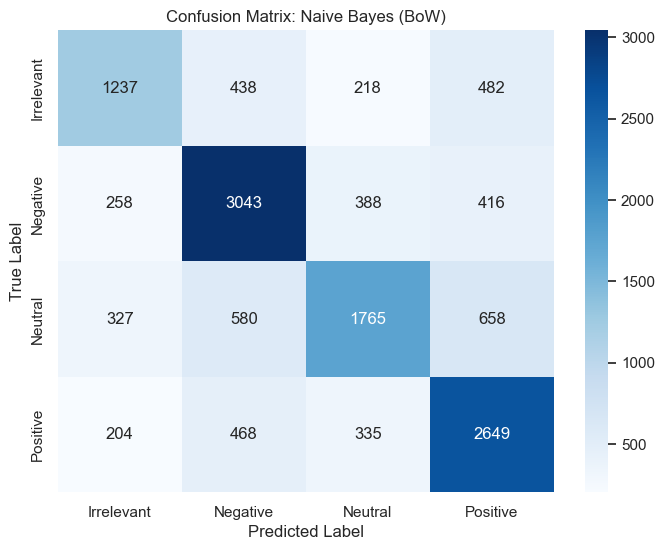

--- Training Linear SVM with BoW ---

Classification Report for Linear SVM with BoW:
              precision    recall  f1-score   support

  Irrelevant       0.70      0.61      0.65      2375
    Negative       0.74      0.80      0.76      4105
     Neutral       0.72      0.65      0.69      3330
    Positive       0.70      0.76      0.73      3656

    accuracy                           0.72     13466
   macro avg       0.72      0.71      0.71     13466
weighted avg       0.72      0.72      0.72     13466



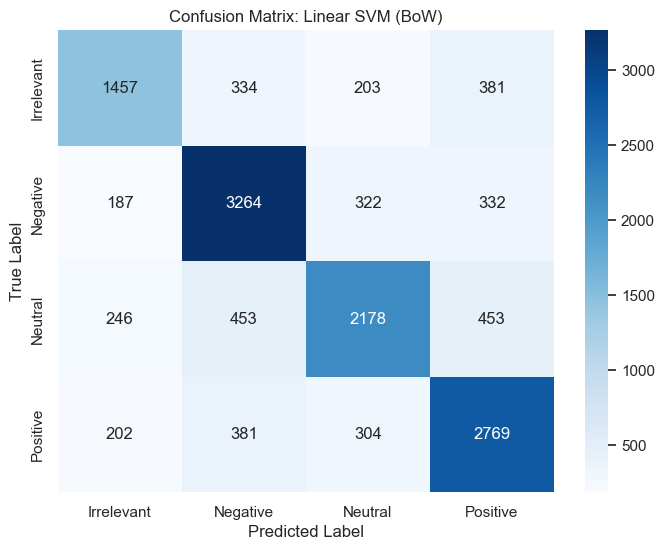

--- Training Logistic Regression with TF-IDF ---

Classification Report for Logistic Regression with TF-IDF:
              precision    recall  f1-score   support

  Irrelevant       0.66      0.54      0.59      2375
    Negative       0.72      0.79      0.75      4105
     Neutral       0.67      0.64      0.65      3330
    Positive       0.69      0.73      0.71      3656

    accuracy                           0.69     13466
   macro avg       0.68      0.67      0.68     13466
weighted avg       0.69      0.69      0.69     13466



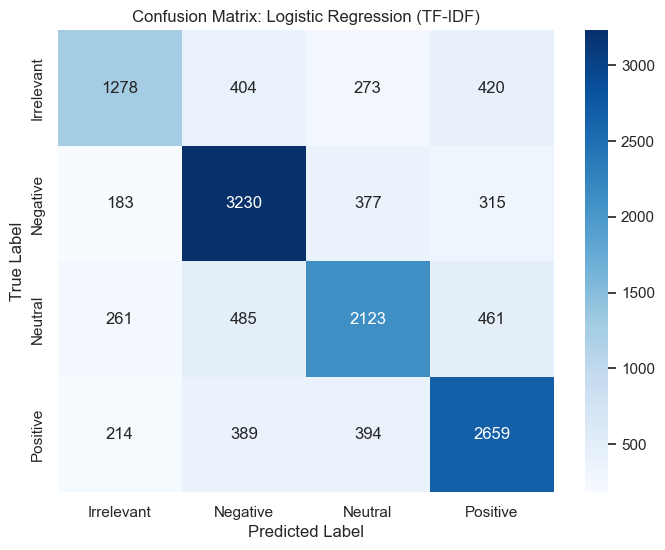

--- Training Linear SVM with TF-IDF ---

Classification Report for Linear SVM with TF-IDF:
              precision    recall  f1-score   support

  Irrelevant       0.68      0.60      0.64      2375
    Negative       0.73      0.79      0.76      4105
     Neutral       0.71      0.65      0.68      3330
    Positive       0.70      0.74      0.72      3656

    accuracy                           0.71     13466
   macro avg       0.71      0.70      0.70     13466
weighted avg       0.71      0.71      0.71     13466



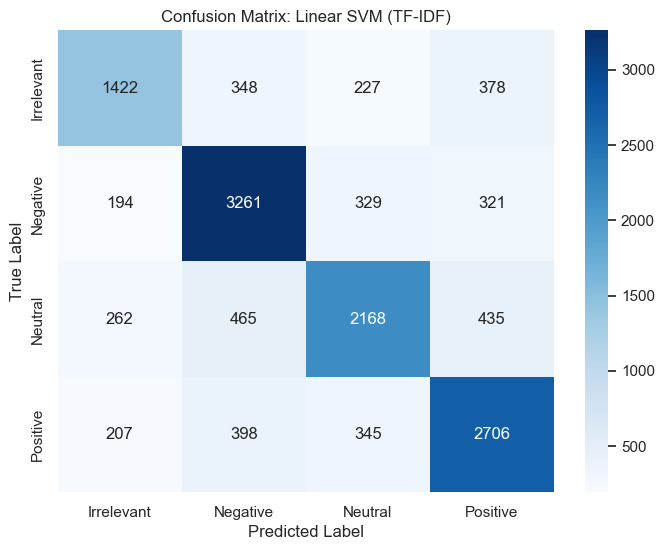

In [26]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name, vectorizer_name):
    print(f"--- Training {model_name} with {vectorizer_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\nClassification Report for {model_name} with {vectorizer_name}:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Irrelevant', 'Negative', 'Neutral', 'Positive'], 
                yticklabels=['Irrelevant', 'Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix: {model_name} ({vectorizer_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return model

# --- Split data for BoW ---
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42, stratify=y)

# --- Split data for TF-IDF ---
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# --- Initialize Models ---
lr_model = LogisticRegression(max_iter=1000, random_state=42)
nb_model = MultinomialNB()
svm_model = LinearSVC(random_state=42)

# --- Train and Evaluate with BoW ---
lr_bow = train_and_evaluate(lr_model, X_train_bow, y_train, X_test_bow, y_test, "Logistic Regression", "BoW")
nb_bow = train_and_evaluate(nb_model, X_train_bow, y_train, X_test_bow, y_test, "Naive Bayes", "BoW")
svm_bow = train_and_evaluate(svm_model, X_train_bow, y_train, X_test_bow, y_test, "Linear SVM", "BoW")

# --- Train and Evaluate with TF-IDF ---
lr_tfidf = train_and_evaluate(lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Logistic Regression", "TF-IDF")
svm_tfidf = train_and_evaluate(svm_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Linear SVM", "TF-IDF")
# Note: Naive Bayes is typically used with counts (BoW), so we'll skip it for TF-IDF for brevity.